In [ ]:
# Step 1: Setup - Imports and API Key
# Loads tools for API calls (requests) and data handling (pandas).
# Get your free API key from https://www.football-data.org/client/register
import requests
import pandas as pd
import numpy as np
from getpass import getpass

# Prompt user for API key (input will be hidden)
print("Get your free API key from: https://www.football-data.org/client/register")
api_key = getpass("Enter your Football-Data.org API key: ")
headers = {'X-Auth-Token': api_key}

print("Setup done—ready to fetch data!")

Get your free API key from: https://www.football-data.org/client/register


In [2]:
# Step 2: Fetch Current 2025-26 PL Matches (Refined)
# API call for all ~380 fixtures/results via official docs endpoint.
# Filters to finished (~30-40 so far) for training; keeps full for predictions.
# Why? All data in one pull—current season performance included for fresh form calcs.
url = 'http://api.football-data.org/v4/competitions/PL/matches?season=2025'
response = requests.get(url, headers=headers)

if response.status_code == 200:
    data = response.json()
    matches = data['matches']
    df = pd.json_normalize(matches)  # Full flat DF with all matches.
    
    # Key cols/rename.
    key_cols = ['homeTeam.name', 'awayTeam.name', 'score.fullTime.home', 'score.fullTime.away', 'utcDate', 'status']
    df = df[key_cols].copy()
    df.columns = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Date', 'Status']
    
    # Clean all: Dates, goals (NaN=0 for scheduled).
    df['Date'] = pd.to_datetime(df['Date'])
    df['FTHG'] = df['FTHG'].fillna(0).astype(int)
    df['FTAG'] = df['FTAG'].fillna(0).astype(int)
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Full save (all matches, incl. scheduled like derby).
    df.to_csv('pl_2025_full.csv', index=False)
    
    # Training slice: Finished only + outcome.
    df_current = df[df['Status'] == 'FINISHED'].copy()
    df_current['Outcome'] = np.where(df_current['FTHG'] > df_current['FTAG'], 1,
                                     np.where(df_current['FTHG'] < df_current['FTAG'], -1, 0))
    
    # Add Outcome to full df for consistency (0 for scheduled).
    df['Outcome'] = np.where(df['FTHG'] > df['FTAG'], 1,
                             np.where(df['FTHG'] < df['FTAG'], -1, 0))
    
    print("Full fetch complete—all ~380 matches grabbed!")
    print(f"Total matches: {len(df)}, Finished: {len(df_current)}")
    print("\nThis season outcomes (finished):")
    print(df_current['Outcome'].value_counts(normalize=True))
    print("\nFirst 5 finished:")
    print(df_current.head(5))
    print("\nUpcoming sample (e.g., derby?):")
    upcoming = df[df['Status'] == 'SCHEDULED'].head()
    print(upcoming[['HomeTeam', 'AwayTeam', 'Date']])
    
    df_current.to_csv('pl_2025_current.csv', index=False)
    print("\nSaved: pl_2025_full.csv (all) & pl_2025_current.csv (training)")
else:
    print(f"Error {response.status_code}: {response.text[:150]}...")
    print("Fix: Check key/URL; try v2 if v4 404s: swap /v4/ to /v2/")

Full fetch complete—all ~380 matches grabbed!
Total matches: 380, Finished: 70

This season outcomes (finished):
Outcome
 1    0.485714
 0    0.257143
-1    0.257143
Name: proportion, dtype: float64

First 5 finished:
                    HomeTeam             AwayTeam  FTHG  FTAG  \
0               Liverpool FC      AFC Bournemouth     4     2   
1             Aston Villa FC  Newcastle United FC     0     0   
2  Brighton & Hove Albion FC            Fulham FC     1     1   
3             Sunderland AFC   West Ham United FC     3     0   
4       Tottenham Hotspur FC           Burnley FC     3     0   

                       Date    Status  Outcome  
0 2025-08-15 19:00:00+00:00  FINISHED        1  
1 2025-08-16 11:30:00+00:00  FINISHED        0  
2 2025-08-16 14:00:00+00:00  FINISHED        0  
3 2025-08-16 14:00:00+00:00  FINISHED        1  
4 2025-08-16 14:00:00+00:00  FINISHED        1  

Upcoming sample (e.g., derby?):
                       HomeTeam              AwayTeam  \
130    

In [3]:
# Step 3: Fetch Historical Data & Merge (for General Model)
# Reusable function to pull one season's matches (same clean as Step 2).
# Loops over 2020-2024 (5 seasons, ~1900 matches) + merges with current for ~1935 total.
# Adds 'Season' col to track (helps weight recent data later).
# Why? Historical teaches patterns; current adds 2025-26 freshness for derby-like preds.
import time  # For rate-limit pause (10 calls/min = ~6s between).

def fetch_season(season_year):
    """Fetches & cleans one PL season's finished matches."""
    url = f'http://api.football-data.org/v4/competitions/PL/matches?season={season_year}'
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        matches = data['matches']
        df_s = pd.json_normalize(matches)
        
        key_cols = ['homeTeam.name', 'awayTeam.name', 'score.fullTime.home', 'score.fullTime.away', 'utcDate', 'status']
        df_s = df_s[key_cols].copy()
        df_s.columns = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'Date', 'Status']
        
        df_s['Date'] = pd.to_datetime(df_s['Date'])
        df_s = df_s[df_s['Status'] == 'FINISHED'].copy()  # Only finished for training.
        df_s['FTHG'] = df_s['FTHG'].fillna(0).astype(int)
        df_s['FTAG'] = df_s['FTAG'].fillna(0).astype(int)
        df_s = df_s.sort_values('Date').reset_index(drop=True)
        
        df_s['Season'] = f"{season_year}-{season_year+1}"
        df_s['Outcome'] = np.where(df_s['FTHG'] > df_s['FTAG'], 1,
                                   np.where(df_s['FTHG'] < df_s['FTAG'], -1, 0))
        
        print(f"Fetched {len(df_s)} matches for {df_s['Season'].iloc[0]}")
        return df_s
    else:
        print(f"Season {season_year} failed: {response.status_code}")
        return None

# Fetch historical seasons (adjust list for more/less).
historical_years = [2020, 2021, 2022, 2023, 2024]
historical_dfs = []

for year in historical_years:
    df_s = fetch_season(year)
    if df_s is not None:
        historical_dfs.append(df_s)
    time.sleep(6)  # Chill for rate limit.

# Merge: Historical + current (add Season to current if missing).
df_current['Season'] = '2025-2026'
if historical_dfs:
    df_historical = pd.concat(historical_dfs, ignore_index=True)
    df_master = pd.concat([df_historical, df_current], ignore_index=True)
else:
    df_master = df_current

# Quick check: Total matches, outcomes across seasons.
print(f"\nMaster DF ready: {len(df_master)} total matches over {df_master['Season'].nunique()} seasons.")
print("Overall outcomes:")
print(df_master['Outcome'].value_counts(normalize=True))
print("\nTeams check (unique home):", df_master['HomeTeam'].nunique())
print("\nSample (recent/current):")
print(df_master.tail(5))  # Last 5 rows for freshness.

# Save master for features/modeling.
df_master.to_csv('pl_master_data.csv', index=False)
print("\nSaved to pl_master_data.csv—next: features!")

Season 2020 failed: 403
Season 2021 failed: 403
Season 2022 failed: 403
Fetched 380 matches for 2023-2024
Fetched 380 matches for 2024-2025

Master DF ready: 830 total matches over 3 seasons.
Overall outcomes:
Outcome
 1    0.438554
-1    0.328916
 0    0.232530
Name: proportion, dtype: float64

Teams check (unique home): 25

Sample (recent/current):
                       HomeTeam                   AwayTeam  FTHG  FTAG  \
825         Newcastle United FC       Nottingham Forest FC     2     0   
826  Wolverhampton Wanderers FC  Brighton & Hove Albion FC     1     1   
827              Aston Villa FC                 Burnley FC     2     1   
828                  Everton FC          Crystal Palace FC     2     1   
829                Brentford FC         Manchester City FC     0     1   

                         Date    Status     Season  Outcome  
825 2025-10-05 13:00:00+00:00  FINISHED  2025-2026        1  
826 2025-10-05 13:00:00+00:00  FINISHED  2025-2026        0  
827 2025-10-05 1

In [4]:
# Step 4: Feature Engineering (Full Code - Overall Form, Venue-Specific Scoring, Full H2H)
# Adds rolling form (last 5 overall games from Outcome), venue-specific goals scored/conceded (last 5 home/away from FTHG/FTAG), full H2H (last 4 including reverses).
# Logic: Pre-match only (shift/rolling); overall form from all games, scoring from venue-specific priors, H2H adjusted for current home.
# Why? Overall form for team vibe, venue scoring for attack fit, H2H for matchup history—all from existing columns.

import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler

df_master = df_master.sort_values('Date').reset_index(drop=True)

# Rolling form (last 5 overall points from Outcome, home or away).
df_master['Home_Points'] = np.where(df_master['Outcome'] == 1, 3, np.where(df_master['Outcome'] == 0, 1, 0))
df_master['Away_Points'] = np.where(df_master['Outcome'] == -1, 3, np.where(df_master['Outcome'] == 0, 1, 0))

# Overall form calculation (last 5 games regardless of venue)
# Create team points for each match
df_master['HomeTeam_Points'] = df_master['Home_Points']
df_master['AwayTeam_Points'] = df_master['Away_Points']

# Calculate overall form for each team
df_master['Home_Form'] = df_master.groupby('HomeTeam')['HomeTeam_Points'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean().fillna(0))
df_master['Away_Form'] = df_master.groupby('AwayTeam')['AwayTeam_Points'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean().fillna(0))
df_master['Form_Diff'] = df_master['Home_Form'] - df_master['Away_Form']

# Venue-specific goals scored/conceded (last 5 home for home team, last 5 away for away team).
df_master['Home_Goals_Scored_Rolling'] = df_master.groupby('HomeTeam')['FTHG'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean().fillna(0))
df_master['Home_Goals_Conceded_Rolling'] = df_master.groupby('HomeTeam')['FTAG'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean().fillna(0))
df_master['Away_Goals_Scored_Rolling'] = df_master.groupby('AwayTeam')['FTAG'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean().fillna(0))
df_master['Away_Goals_Conceded_Rolling'] = df_master.groupby('AwayTeam')['FTHG'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean().fillna(0))

# Full H2H (including reversed roles, last 4 meetings).
df_master['Team_Pair'] = df_master.apply(lambda row: tuple(sorted([row['HomeTeam'], row['AwayTeam']])), axis=1)
df_master['H2H_Current_Home_Win'] = np.where(df_master['Outcome'] == 1, 1, 0)
df_master['H2H_Current_Home_Goal_Diff'] = df_master['FTHG'] - df_master['FTAG']

# Flip for reversed roles.
df_master['H2H_Current_Home_Win'] = np.where(df_master['HomeTeam'] == df_master['Team_Pair'].apply(lambda x: x[0]), df_master['H2H_Current_Home_Win'], 1 - df_master['H2H_Current_Home_Win'])
df_master['H2H_Current_Home_Goal_Diff'] = np.where(df_master['HomeTeam'] == df_master['Team_Pair'].apply(lambda x: x[0]), df_master['H2H_Current_Home_Goal_Diff'], -df_master['H2H_Current_Home_Goal_Diff'])

df_master['H2H_Home_Win_Rate'] = df_master.groupby('Team_Pair')['H2H_Current_Home_Win'].transform(lambda x: x.shift().rolling(4, min_periods=1).mean().fillna(0.5))
df_master['H2H_Goal_Diff_Avg'] = df_master.groupby('Team_Pair')['H2H_Current_Home_Goal_Diff'].transform(lambda x: x.shift().rolling(4, min_periods=1).mean().fillna(0))

# Encodings.
le = LabelEncoder()
all_teams = sorted(set(df_master['HomeTeam']) | set(df_master['AwayTeam']))
le.fit(all_teams)
df_master['Home_Encoded'] = le.transform(df_master['HomeTeam'])
df_master['Away_Encoded'] = le.transform(df_master['AwayTeam'])

# Feature scaling for better model performance
scaler = StandardScaler()
numerical_features = ['Home_Form', 'Away_Form', 'Form_Diff', 'Home_Goals_Scored_Rolling', 'Home_Goals_Conceded_Rolling', 
                     'Away_Goals_Scored_Rolling', 'Away_Goals_Conceded_Rolling', 'H2H_Home_Win_Rate', 'H2H_Goal_Diff_Avg']
df_master[numerical_features] = scaler.fit_transform(df_master[numerical_features])

# Drop temp.
df_master.drop(['Home_Points', 'Away_Points', 'HomeTeam_Points', 'AwayTeam_Points', 'Team_Pair', 'H2H_Current_Home_Win', 'H2H_Current_Home_Goal_Diff'], axis=1, inplace=True)

print("Step 4 complete—overall form, venue-specific scoring, full H2H added.")
print(df_master[['HomeTeam', 'AwayTeam', 'Home_Form', 'Away_Form', 'Home_Goals_Scored_Rolling', 'Away_Goals_Scored_Rolling', 'H2H_Home_Win_Rate', 'Outcome']].head())
df_master.to_csv('pl_master_features.csv', index=False)

Step 4 complete—overall form, venue-specific scoring, full H2H added.
                    HomeTeam              AwayTeam  Home_Form  Away_Form  \
0                 Burnley FC    Manchester City FC  -1.845316  -1.635111   
1                 Arsenal FC  Nottingham Forest FC  -1.845316  -1.635111   
2            AFC Bournemouth    West Ham United FC  -1.845316  -1.635111   
3  Brighton & Hove Albion FC         Luton Town FC  -1.845316  -1.635111   
4                 Everton FC             Fulham FC  -1.845316  -1.635111   

   Home_Goals_Scored_Rolling  Away_Goals_Scored_Rolling  H2H_Home_Win_Rate  \
0                  -1.990482                  -2.043169          -0.035921   
1                  -1.990482                  -2.043169          -0.035921   
2                  -1.990482                  -2.043169          -0.035921   
3                  -1.990482                  -2.043169          -0.035921   
4                  -1.990482                  -2.043169          -0.035921   

   O

In [5]:
%pip install xgboost scikit-learn==1.6.1

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import numpy as np

# Chronological split.
df_master_sorted = df_master.sort_values('Date').reset_index(drop=True)
split_idx = int(len(df_master_sorted) * 0.8)
train_df = df_master_sorted.iloc[:split_idx]
test_df = df_master_sorted.iloc[split_idx:]

features = ['Home_Form', 'Away_Form', 'Form_Diff', 'Home_Goals_Scored_Rolling', 'Home_Goals_Conceded_Rolling', 
            'Away_Goals_Scored_Rolling', 'Away_Goals_Conceded_Rolling', 'H2H_Home_Win_Rate', 'H2H_Goal_Diff_Avg', 
            'Home_Encoded', 'Away_Encoded']
X_train = train_df[features]
y_train = train_df['Outcome'] + 1  # Models like 0,1,2.
X_test = test_df[features]
y_test = test_df['Outcome'] + 1

# Models.
xgb = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1, subsample=0.8, eval_metric='mlogloss', random_state=42)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
lr = LogisticRegression(random_state=42, max_iter=1000)

# Cross-validation scores
print("Cross-validation scores (5-fold):")
xgb_cv_scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='accuracy')
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
lr_cv_scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')

print(f"XGBoost CV: {xgb_cv_scores.mean():.3f} (+/- {xgb_cv_scores.std() * 2:.3f})")
print(f"Random Forest CV: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")
print(f"Logistic Regression CV: {lr_cv_scores.mean():.3f} (+/- {lr_cv_scores.std() * 2:.3f})")

# Fit models.
xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

# Get individual predictions and accuracies.
xgb_pred = xgb.predict(X_test)
rf_pred = rf.predict(X_test)
lr_pred = lr.predict(X_test)

xgb_acc = accuracy_score(y_test, xgb_pred)
rf_acc = accuracy_score(y_test, rf_pred)
lr_acc = accuracy_score(y_test, lr_pred)

print(f"\nTest accuracies: XGBoost {xgb_acc:.3f}, RF {rf_acc:.3f}, LR {lr_acc:.3f}")

# Weights based on accuracies.
total_acc = xgb_acc + rf_acc + lr_acc
weights = [xgb_acc / total_acc, rf_acc / total_acc, lr_acc / total_acc]

# Weighted ensemble predict_proba.
xgb_probs = xgb.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)
lr_probs = lr.predict_proba(X_test)
ensemble_probs = (weights[0] * xgb_probs + weights[1] * rf_probs + weights[2] * lr_probs)
y_pred = np.argmax(ensemble_probs, axis=1) - 1  # Shift back.
accuracy = accuracy_score(y_test - 1, y_pred)
print(f"Model trained! Test accuracy (Weighted Ensemble): {accuracy:.3f}")

# Report.
unique_labels = sorted(np.unique(y_test - 1))
target_names = {1: 'Home Win', 0: 'Draw', -1: 'Away Win'}
report_names = [target_names[label] for label in unique_labels]
print(classification_report(y_test - 1, y_pred, labels=unique_labels, target_names=report_names, digits=2))

print(f"\nOutcomes predicted correctly: {sum(y_test - 1 == y_pred)} / {len(y_test)}")

# Confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test - 1, y_pred, labels=[-1, 0, 1])
print(f"Away Win | Draw | Home Win")
print(f"{cm[0]} | {cm[1]} | {cm[2]}")

# Feature importances from XGBoost.
importances = xgb.feature_importances_
top_indices = np.argsort(importances)[-5:]
print("\nTop 5 feature importances (from XGBoost):")
for i in top_indices:
    print(f"  {features[i]}: {importances[i]:.3f}")

# For prediction, we'll use weighted probs in Step 7.

Note: you may need to restart the kernel to use updated packages.
Cross-validation scores (5-fold):
XGBoost CV: 0.449 (+/- 0.079)
Random Forest CV: 0.467 (+/- 0.074)
Logistic Regression CV: 0.494 (+/- 0.068)

Test accuracies: XGBoost 0.464, RF 0.482, LR 0.512
Model trained! Test accuracy (Weighted Ensemble): 0.482
              precision    recall  f1-score   support

    Away Win       0.39      0.40      0.40        50
        Draw       0.48      0.28      0.35        39
    Home Win       0.53      0.64      0.58        77

    accuracy                           0.48       166
   macro avg       0.47      0.44      0.44       166
weighted avg       0.48      0.48      0.47       166


Outcomes predicted correctly: 80 / 166

Confusion Matrix:
Away Win | Draw | Home Win
[20  3 27] | [12 11 16] | [19  9 49]

Top 5 feature importances (from XGBoost):
  Away_Form: 0.087
  Away_Goals_Conceded_Rolling: 0.089
  Away_Goals_Scored_Rolling: 0.090
  H2H_Goal_Diff_Avg: 0.102
  Form_Diff: 0.116


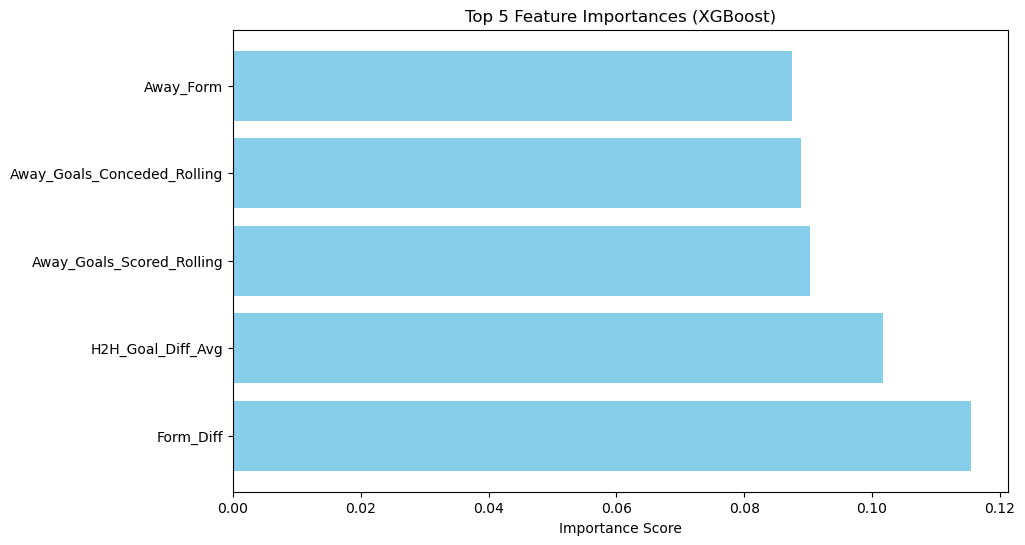

In [6]:
# Visualization of Top 5 Important Features
import matplotlib.pyplot as plt

features = ['Home_Form', 'Away_Form', 'Form_Diff', 'Home_Goals_Scored_Rolling', 'Home_Goals_Conceded_Rolling', 
            'Away_Goals_Scored_Rolling', 'Away_Goals_Conceded_Rolling', 'H2H_Home_Win_Rate', 'H2H_Goal_Diff_Avg', 
            'Home_Encoded', 'Away_Encoded']
importances = xgb.feature_importances_
top_indices = np.argsort(importances)[-5:]
top_features = [features[i] for i in top_indices]
top_importances = importances[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance Score')
plt.title('Top 5 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()  # Highest at top
plt.show()

In [7]:
# Step 6: User Input (Print Mapping & Ask for IDs)
# Prints ID to team name mapping, asks for home/away IDs.

import datetime

# Get unique teams and mappings.
unique_teams = sorted(set(df_master['HomeTeam']) | set(df_master['AwayTeam']))
id_to_team = {idx: team for idx, team in enumerate(unique_teams)}

# Print mapping.
print("\nTeam ID Mapping:")
for idx, team in id_to_team.items():
    print(f"ID {idx}: {team}")

# Ask for inputs.
home_id = int(input("\nEnter home team ID: "))
away_id = int(input("Enter away team ID: "))

# Map IDs to names.
home = id_to_team[home_id]
away = id_to_team[away_id]

print(f"\nSelected: Home {home} (ID {home_id}) vs Away {away} (ID {away_id})")

# Check if match has already been played.
today = datetime.date.today()
match_row = df[(df['HomeTeam'] == home) & (df['AwayTeam'] == away)]
if not match_row.empty:
    match_date = match_row['Date'].dt.date.iloc[0]
    status = match_row['Status'].iloc[0]
    if match_date < today or (match_date == today and status == 'FINISHED'):
        fthg, ftag = int(match_row['FTHG'].iloc[0]), int(match_row['FTAG'].iloc[0])
        outcome = match_row['Outcome'].iloc[0]
        outcome_str = "Home Win" if outcome == 1 else "Away Win" if outcome == -1 else "Draw"
        print(f"\nAlready played ({match_date})! {home} {fthg}-{ftag} {away} ({outcome_str}).")
    else:
        print(f"Upcoming match on {match_date}.")
        print("Run Step 7 for prediction probabilities.")
else:
    print("Match not found in fixtures—check IDs.")


Team ID Mapping:
ID 0: AFC Bournemouth
ID 1: Arsenal FC
ID 2: Aston Villa FC
ID 3: Brentford FC
ID 4: Brighton & Hove Albion FC
ID 5: Burnley FC
ID 6: Chelsea FC
ID 7: Crystal Palace FC
ID 8: Everton FC
ID 9: Fulham FC
ID 10: Ipswich Town FC
ID 11: Leeds United FC
ID 12: Leicester City FC
ID 13: Liverpool FC
ID 14: Luton Town FC
ID 15: Manchester City FC
ID 16: Manchester United FC
ID 17: Newcastle United FC
ID 18: Nottingham Forest FC
ID 19: Sheffield United FC
ID 20: Southampton FC
ID 21: Sunderland AFC
ID 22: Tottenham Hotspur FC
ID 23: West Ham United FC
ID 24: Wolverhampton Wanderers FC

Selected: Home Manchester City FC (ID 15) vs Away Crystal Palace FC (ID 7)
Upcoming match on 2026-03-21.
Run Step 7 for prediction probabilities.


In [8]:
# Step 7: Feature Calculation & Prediction (Complete)
# Calculates features for selected teams, predicts with weighted ensemble.

import datetime

# Calculate features for the selected match.
# Get last 5 games for overall form calculation.
home_games_all = df_master[(df_master['HomeTeam'] == home) | (df_master['AwayTeam'] == home)].sort_values('Date')
away_games_all = df_master[(df_master['HomeTeam'] == away) | (df_master['AwayTeam'] == away)].sort_values('Date')

# For current form, we need the last 5 overall games (home or away) with outcomes
def calculate_overall_form(team_name, df_master):
    # Get all games for this team
    team_games = df_master[(df_master['HomeTeam'] == team_name) | (df_master['AwayTeam'] == team_name)].sort_values('Date')
    if len(team_games) == 0:
        return 0.0
    
    # Calculate points for last 5 games
    points = []
    for _, game in team_games.tail(5).iterrows():
        if game['HomeTeam'] == team_name:
            # Team was home
            if game['Outcome'] == 1:  # Home win
                points.append(3)
            elif game['Outcome'] == 0:  # Draw
                points.append(1)
            else:  # Home loss
                points.append(0)
        else:
            # Team was away
            if game['Outcome'] == -1:  # Away win
                points.append(3)
            elif game['Outcome'] == 0:  # Draw
                points.append(1)
            else:  # Away loss
                points.append(0)
    
    return sum(points) / len(points) if points else 0.0

# Calculate overall form
home_form = calculate_overall_form(home, df_master)
away_form = calculate_overall_form(away, df_master)
form_diff = home_form - away_form

# Get last 5 home games for home team (for venue-specific scoring)
home_games = df_master[df_master['HomeTeam'] == home].sort_values('Date').tail(5)
home_goals_scored_rolling = home_games['FTHG'].mean() if len(home_games) > 0 else 0
home_goals_conceded_rolling = home_games['FTAG'].mean() if len(home_games) > 0 else 0

# Get last 5 away games for away team (for venue-specific scoring)
away_games = df_master[df_master['AwayTeam'] == away].sort_values('Date').tail(5)
away_goals_scored_rolling = away_games['FTAG'].mean() if len(away_games) > 0 else 0
away_goals_conceded_rolling = away_games['FTHG'].mean() if len(away_games) > 0 else 0

# Calculate H2H history (last 4 meetings between these teams)
h2h_matches = df_master[((df_master['HomeTeam'] == home) & (df_master['AwayTeam'] == away)) |
                        ((df_master['HomeTeam'] == away) & (df_master['AwayTeam'] == home))].sort_values('Date')

h2h_history = []
for _, match in h2h_matches.tail(4).iterrows():
    game_info = {
        'date': match['Date'],
        'home_team': match['HomeTeam'],
        'away_team': match['AwayTeam'],
        'score': f"{match['FTHG']}-{match['FTAG']}",
        'win_for_home': 1 if (match['HomeTeam'] == home and match['Outcome'] == 1) or (match['AwayTeam'] == home and match['Outcome'] == -1) else 0.5 if match['Outcome'] == 0 else 0,
        'goal_diff': (match['FTHG'] - match['FTAG']) if match['HomeTeam'] == home else (match['FTAG'] - match['FTHG'])
    }
    h2h_history.append(game_info)

h2h_history = sorted(h2h_history, key=lambda x: x['date'], reverse=True)[:4]  # Most recent 4
wins = sum(1 for g in h2h_history if g['win_for_home'] == 1)
draws = sum(1 for g in h2h_history if g['win_for_home'] == 0.5)
losses = sum(1 for g in h2h_history if g['win_for_home'] == 0)
h2h_home_win_rate = wins / len(h2h_history) if h2h_history else 0.5
h2h_goal_diff_avg = sum(g['goal_diff'] for g in h2h_history) / len(h2h_history) if h2h_history else 0

# Print last 4 H2H games if available.
print("\nLast 4 Head-to-Head Games:")
if len(h2h_history) >= 1:
    for i, game in enumerate(h2h_history, 1):  # Most recent 4
        outcome_str = f"Win for {home}" if game['win_for_home'] == 1 else f"Draw" if game['win_for_home'] == 0.5 else f"Loss for {home}"
        print(f"  {i}. {game['date'].date()} - {game['home_team']} {game['score']} {game['away_team']} ({outcome_str})")
else:
    print("  No prior head-to-head games recorded.")

print(f"\nH2H Stats (from {home}'s perspective, based on last {len(h2h_history)} games):")
print(f"Wins: {wins} out of {len(h2h_history)} games")
print(f"Draws: {draws}")
print(f"Losses: {losses}")
print(f"Win Rate: {h2h_home_win_rate:.1%}")
print(f"Average Goal Difference: {h2h_goal_diff_avg:.1f}")

# Print last 5 home games for home team
print(f"\nLast 5 Home Games for {home} (used for scoring averages):")
if len(home_games) > 0:
    for i, (_, game) in enumerate(home_games.iterrows(), 1):
        outcome = "Win" if game['Outcome'] == 1 else "Draw" if game['Outcome'] == 0 else "Loss"
        print(f"  {i}. {game['Date'].date()} - {home} {game['FTHG']}-{game['FTAG']} {game['AwayTeam']} ({outcome})")
else:
    print("  No home games found.")

# Print last 5 away games for away team
print(f"\nLast 5 Away Games for {away} (used for scoring averages):")
if len(away_games) > 0:
    for i, (_, game) in enumerate(away_games.iterrows(), 1):
        outcome = "Win" if game['Outcome'] == -1 else "Draw" if game['Outcome'] == 0 else "Loss"
        print(f"  {i}. {game['Date'].date()} - {game['HomeTeam']} {game['FTHG']}-{game['FTAG']} {away} ({outcome})")
else:
    print("  No away games found.")

# Encodings.
home_enc = home_id
away_enc = away_id

# Scale numerical features using the same scaler from Step 4
numerical_features_values = [home_form, away_form, form_diff, home_goals_scored_rolling, home_goals_conceded_rolling, 
                            away_goals_scored_rolling, away_goals_conceded_rolling, h2h_home_win_rate, h2h_goal_diff_avg]
scaled_numerical = scaler.transform([numerical_features_values])[0]

# Predict with weighted ensemble probs.
input_data = np.array([[scaled_numerical[0], scaled_numerical[1], scaled_numerical[2], scaled_numerical[3], scaled_numerical[4], 
                        scaled_numerical[5], scaled_numerical[6], scaled_numerical[7], scaled_numerical[8], 
                        home_enc, away_enc]])
xgb_prob = xgb.predict_proba(input_data)[0]
rf_prob = rf.predict_proba(input_data)[0]
lr_prob = lr.predict_proba(input_data)[0]
# Using dynamic weights from Step 5.
probs = (weights[0] * xgb_prob + weights[1] * rf_prob + weights[2] * lr_prob)
pred_idx = np.argmax(probs)
pred = [-1, 0, 1][pred_idx]  # Match highest prob to outcome

# Use team names in probs.
outcome_str = f"{home} Win" if pred == 1 else f"{away} Win" if pred == -1 else "Draw"
print(f"\nPrediction for {home} vs {away}:")
print(f"{home} Form (last 5 overall): {home_form:.2f} pts")
print(f"{away} Form (last 5 overall): {away_form:.2f} pts")
print(f"{home} Scoring (last 5 home): {home_goals_scored_rolling:.1f} avg goals scored, {home_goals_conceded_rolling:.1f} conceded")
print(f"{away} Scoring (last 5 away): {away_goals_scored_rolling:.1f} avg goals scored, {away_goals_conceded_rolling:.1f} conceded")
print(f"H2H {home} Win Rate: {h2h_home_win_rate:.1%}")
print(f"Predicted: {outcome_str}")
print("Probabilities:")
print(f"  {home} Win: {probs[2]:.1%}")
print(f"  Draw: {probs[1]:.1%}")
print(f"  {away} Win: {probs[0]:.1%}")


Last 4 Head-to-Head Games:
  1. 2025-04-12 - Manchester City FC 5-2 Crystal Palace FC (Win for Manchester City FC)
  2. 2024-12-07 - Crystal Palace FC 2-2 Manchester City FC (Draw)
  3. 2024-04-06 - Crystal Palace FC 2-4 Manchester City FC (Win for Manchester City FC)
  4. 2023-12-16 - Manchester City FC 2-2 Crystal Palace FC (Draw)

H2H Stats (from Manchester City FC's perspective, based on last 4 games):
Wins: 2 out of 4 games
Draws: 2
Losses: 0
Win Rate: 50.0%
Average Goal Difference: 1.2

Last 5 Home Games for Manchester City FC (used for scoring averages):
  1. 2025-05-02 - Manchester City FC 1-0 Wolverhampton Wanderers FC (Win)
  2. 2025-05-20 - Manchester City FC 3-1 AFC Bournemouth (Win)
  3. 2025-08-23 - Manchester City FC 0-2 Tottenham Hotspur FC (Loss)
  4. 2025-09-14 - Manchester City FC 3-0 Manchester United FC (Win)
  5. 2025-09-27 - Manchester City FC 5-1 Burnley FC (Win)

Last 5 Away Games for Crystal Palace FC (used for scoring averages):
  1. 2025-05-25 - Liverpool F

c:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\prana\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
